## Imports

In [ ]:
pip install vaderSentiment

In [ ]:
pip install preprocessor

In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import preprocessor as prepro
import seaborn as sns
import spacy
import heapq
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools
from collections import Counter
import heapq
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/488 Final Project
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/16acK5vHoUBnbKlGDTa4xxRa2tqUMl6E1/488 Final Project
'CO2 Time Series Forecasting.ipynb'
'Copy of A3 Notebook.ipynb'
 Graphs.gsheet
'Netflix 2019 Sentiment.ipynb'
'Netflix and Covid - Effect on Energy Consumption.gslides'
'Netflix Streaming Notes.gdoc'
 netflixUSA2019.json
 netflixUSA2020.json
 netflixUSA2021.json
 Notebook.ipynb


## Netflix 2019 Tweets

---



## Preprocess Tweets

In [ ]:
pd.set_option('max_colwidth', 20)
tweets19 = pd.read_json('netflixUSA2019.json', lines=True)

# Set-up patterns to be removed fro the tweets
pat1 = r"http\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
pat7 = r"\n"
pat8 = '\r\n'
pat9 = r'|'.join((r'&amp;',r'&copy;',r'&reg;',r'&quot;',r'&gt;',r'&lt;',r'&nbsp;',r'&apos;',r'&cent;',r'&euro;',r'&pound;'))
# Combine all patterns
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7, pat8, pat9))

# replace the patterns with an empty string
tweets19['stripped'] =  [re.sub(combined_pat, '', w) for w in tweets19.content]

# might have double spaces now (because of empty string replacements above) - remove double empty spaces
tweets19['stripped']  = [re.sub(r"  ", ' ', w) for w in tweets19.loc[:,'stripped']]

In [ ]:
# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
tweets19['C_Score'] = np.nan
for index, row in tweets19.iterrows(): 
    tweets19.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']

In [ ]:
# create new column
sentiment = []

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in tweets19.iterrows(): 
    if tweets19.loc[index, 'C_Score'] > 0.05 : 
        sentiment.append("Positive")      
    elif tweets19.loc[index, 'C_Score'] < -0.05 :
        sentiment.append("Negative")    
    else :
        sentiment.append("Neutral")    

tweets19['Sentiment'] = sentiment
tweets19['Sentiment'] = tweets19['Sentiment'].astype("category")

## Sentiment Distribution

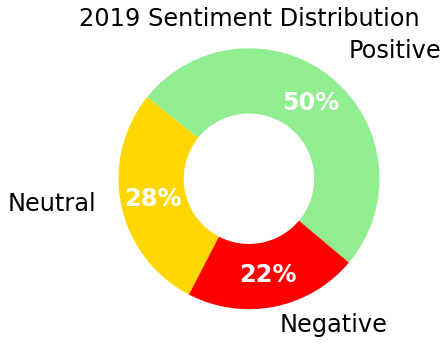

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9,6), subplot_kw=dict(aspect='equal'))

#Get count by sentiment category from tweets21
sentiment_counts19 = tweets19.Sentiment.value_counts()
labels = sentiment_counts19.index

# Define colors
color_palette_list = ['lightgreen', 'gold', 'red', 'orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts19, wedgeprops=dict(width=0.5), startangle=-40,
        colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
  ang = (p.theta2 - p.theta1)/2.+ p.theta1
  y = np.sin(np.deg2rad(ang))
  x = np.cos(np.deg2rad(ang))
  horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
  connectionstyle = "angle,angleA=0,angleB={}".format(ang)
  ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y), 
              horizontalalignment=horizontalalignment)
  
# Set Title
ax.set_title("2019 Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

In [ ]:
import numpy as np
import re

# Let's try to identify tweets that are about the environment
tweets19['environment'] = np.where(tweets19.stripped.str.contains('(?:^|\W)(carbon|emissions|footprint|pollute|pollution|energy|waste|environment)(?:$|\W)',                                                                                                      # beer|booze|brew|bottle|pint|hops|drink|beach
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about carbon emissions
tweets19['carbon'] = np.where(tweets19.stripped.str.contains('(?:^|\W)(carbon emissions|carbon footprint)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about watching netflix for too long
tweets19['watch'] = np.where(tweets19.stripped.str.contains('(?:^|\W)(binge|hours|long|watch|habit)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about cutting back on Netflix
tweets19['habits'] = np.where(tweets19.stripped.str.contains('(?:^|\W)(stop binging|cut back|stop watching|watch less)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)
 
# How many tweets of each topic?
print(f"Environment {tweets19['environment'].sum()}")
print(f"Carbon Emissions {tweets19['carbon'].sum()}")
print(f"Watch {tweets19['watch'].sum()}")
print(f"Habits {tweets19['habits'].sum()}")

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Environment 514
Carbon Emissions 3
Watch 38124
Habits 414


## Netflix 2020 Tweets

---



## Preprocess Tweets

In [ ]:
pd.set_option('max_colwidth', 20)
tweets20 = pd.read_json('netflixUSA2020.json', lines=True)

# Set-up patterns to be removed fro the tweets
pat1 = r"http\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
pat7 = r"\n"
pat8 = '\r\n'
pat9 = r'|'.join((r'&amp;',r'&copy;',r'&reg;',r'&quot;',r'&gt;',r'&lt;',r'&nbsp;',r'&apos;',r'&cent;',r'&euro;',r'&pound;'))
# Combine all patterns
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7, pat8, pat9))

# replace the patterns with an empty string
tweets20['stripped'] =  [re.sub(combined_pat, '', w) for w in tweets20.content]

# might have double spaces now (because of empty string replacements above) - remove double empty spaces
tweets20['stripped']  = [re.sub(r"  ", ' ', w) for w in tweets20.loc[:,'stripped']]

In [ ]:
# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
tweets20['C_Score'] = np.nan
for index, row in tweets20.iterrows(): 
    tweets20.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']

In [ ]:
# create new column
sentiment = []

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in tweets20.iterrows(): 
    if tweets20.loc[index, 'C_Score'] > 0.05 : 
        sentiment.append("Positive")      
    elif tweets20.loc[index, 'C_Score'] < -0.05 :
        sentiment.append("Negative")    
    else :
        sentiment.append("Neutral")    

tweets20['Sentiment'] = sentiment
tweets20['Sentiment'] = tweets20['Sentiment'].astype("category")

## Sentiment Distribution

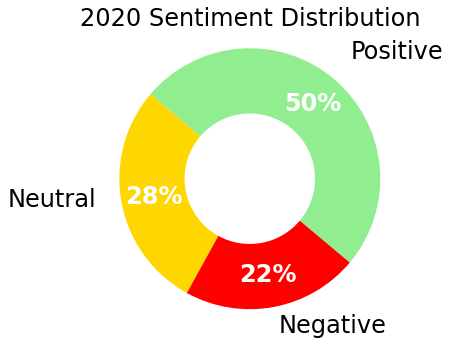

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9,6), subplot_kw=dict(aspect='equal'))

#Get count by sentiment category from tweets21
sentiment_counts20 = tweets20.Sentiment.value_counts()
labels = sentiment_counts20.index

# Define colors
color_palette_list = ['lightgreen', 'gold', 'red', 'orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts20, wedgeprops=dict(width=0.5), startangle=-40,
        colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
  ang = (p.theta2 - p.theta1)/2.+ p.theta1
  y = np.sin(np.deg2rad(ang))
  x = np.cos(np.deg2rad(ang))
  horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
  connectionstyle = "angle,angleA=0,angleB={}".format(ang)
  ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y), 
              horizontalalignment=horizontalalignment)
  
# Set Title
ax.set_title("2020 Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

In [ ]:
import numpy as np
import re

# Let's try to identify tweets that are about the environment
tweets20['environment'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(carbon|emissions|footprint|pollute|pollution|energy|waste|environment)(?:$|\W)',                                                                                                      # beer|booze|brew|bottle|pint|hops|drink|beach
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about carbon emissions
tweets20['carbon'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(carbon emissions|carbon footprint)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about watching netflix for too long
tweets20['watch'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(binge|hours|long|watch|habit)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about cutting back on Netflix
tweets20['habits'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(stop binging|cut back|stop watching|watch less)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)
 
# How many tweets of each topic?
print(f"Environment {tweets20['environment'].sum()}")
print(f"Carbon Emissions {tweets20['carbon'].sum()}")
print(f"Watch {tweets20['watch'].sum()}")
print(f"Habits {tweets20['habits'].sum()}")

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Environment 840
Carbon Emissions 5
Watch 49765
Habits 604


In [ ]:
for i in range(5):
    print(tweets20[tweets20['carbon'] == 1].content.iloc[i], tweets20[tweets20['carbon'] == 1].content.iloc[i]) 
    print('\n')

@cathymcmorris Maybe talk to your farmers about “no till” practices. We can curb carbon emissions. Check it out, doesn’t sound to hard. Netflix  “Kiss the Ground” @cathymcmorris Maybe talk to your farmers about “no till” practices. We can curb carbon emissions. Check it out, doesn’t sound to hard. Netflix  “Kiss the Ground”


Absolutely loving Down to Earth, the @netflix original.  Started off watching because yes,  I’m a fan of @ZacEfron 🤷🏻‍♀️ but it’s extremely interesting! Definitely makes you think about ways of reducing our carbon footprint. #DownToEarthWithZacEfron Absolutely loving Down to Earth, the @netflix original.  Started off watching because yes,  I’m a fan of @ZacEfron 🤷🏻‍♀️ but it’s extremely interesting! Definitely makes you think about ways of reducing our carbon footprint. #DownToEarthWithZacEfron


Watch Down to Earth on Netflix and learn about all of the sustainable efforts around the world whilst the USA does NOTHING to reduce our carbon footprint Watch Down to Ea

## Sentiment Distribution over Tweets about the Environment

In [ ]:
tweets20enviro = tweets20.loc[(tweets20.environment == 1)]

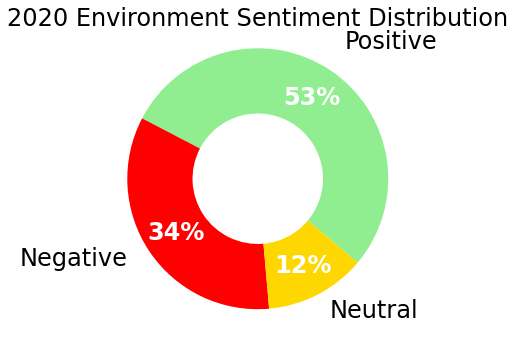

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets20enviro.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'red', 'gold','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("2020 Environment Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## Sentiment Distribution over Tweets about Watching Habits

In [ ]:
tweets20watch = tweets20.loc[(tweets20.watch == 1)]

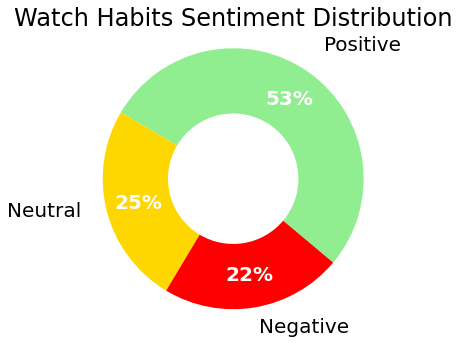

In [ ]:
# Set font size
plt.rcParams['font.size']=20

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets20watch.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'gold', 'red','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Watch Habits Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## Negative Word Cloud

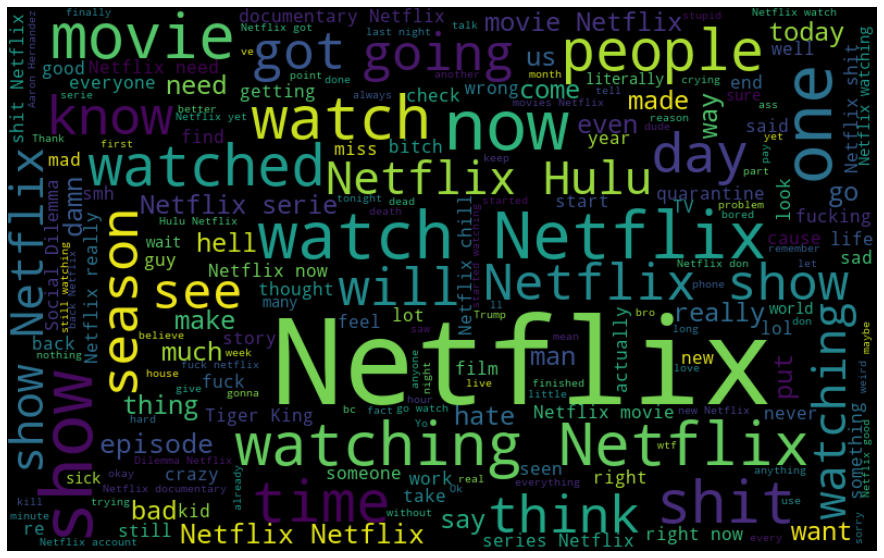

In [ ]:
# 1. Import module 
from wordcloud import WordCloud

# 2. Create bag of words for tweets of Negative sentiment
all_neg_words = ' '.join([text for text in tweets20[tweets20['Sentiment'] == 'Negative']['stripped']])

# 3. Generate Word Cloud
wordcloud = WordCloud(collocations=True, width=800, height=500, random_state=5, max_font_size=110).generate(all_neg_words)

# 4. Visulaize Cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Negative Word Cloud about the Environment

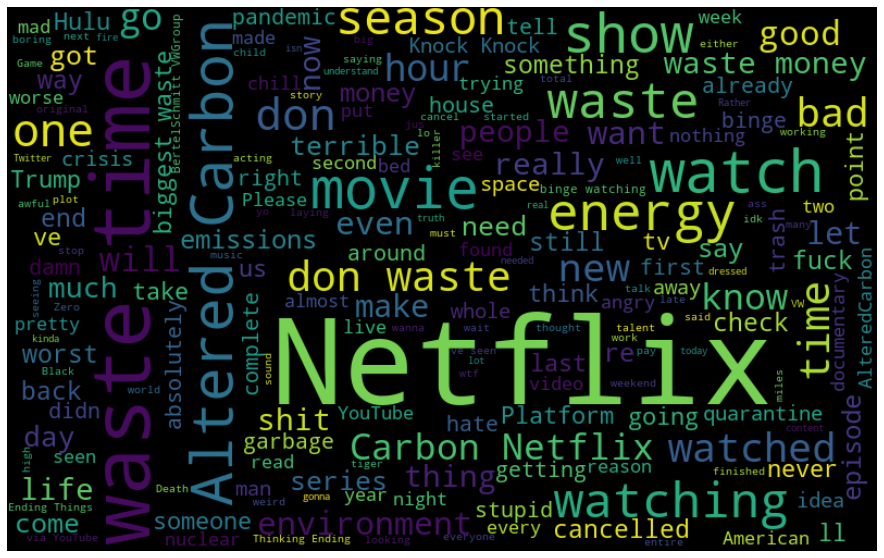

In [ ]:
# 1. Create bag of words for tweets of Negative sentiment
all_neg_words = ' '.join([text for text in tweets20enviro[tweets20enviro['Sentiment'] == 'Negative']['stripped']])

# 2. Generate Word Cloud
wordcloud = WordCloud(collocations=True, width=800, height=500, random_state=5, max_font_size=110).generate(all_neg_words)

# 3. Visulaize Cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Documentary Research

In [ ]:
# Kiss the Ground, A Life on Our Planet, Down to Earth with Zac Efron

# Let's try to identify tweets that are about Kiss the Ground
tweets20['KissTheGround'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(kiss the ground)(?:$|\W)',                                                                                                      # beer|booze|brew|bottle|pint|hops|drink|beach
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about David Attenborough: A Life on Our Planet
tweets20['ALifeOnOurPlanet'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(david attenborough: a life on our planet|a life on our planet|david attenborough)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about Down to Earth with Zac Efron
tweets20['DownToEarth'] = np.where(tweets20.stripped.str.contains('(?:^|\W)(down to earth with zac efron|down to earth)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)
 
# How many tweets of each topic?
print(f"Kiss the Ground {tweets20['KissTheGround'].sum()}")
print(f"A Life on our Planet {tweets20['ALifeOnOurPlanet'].sum()}")
print(f"Down to Earth {tweets20['DownToEarth'].sum()}")

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Kiss the Ground 22
A Life on our Planet 93
Down to Earth 229


In [ ]:
for i in range(22):
    print(tweets20[tweets20['KissTheGround'] == 1].user.iloc[i], tweets20[tweets20['KissTheGround'] == 1].content.iloc[i]) 
    print('\n')

{'username': 'lafsatfriday', 'displayname': 'Bj Freitag', 'id': 191734804, 'description': 'United Brotherhood of Carpenter, union carpenter building america,  RIP Pops, RIP LA @lfinspokane', 'rawDescription': 'United Brotherhood of Carpenter, union carpenter building america,  RIP Pops, RIP LA @lfinspokane', 'descriptionUrls': [], 'verified': False, 'created': '2010-09-17T06:03:42+00:00', 'followersCount': 227, 'friendsCount': 354, 'statusesCount': 13750, 'favouritesCount': 12553, 'listedCount': 13, 'mediaCount': 1373, 'location': ' Eastern Washington', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/939900343420203008/UGLiasfz_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/191734804/1498360138', 'url': 'https://twitter.com/lafsatfriday'} @cathymcmorris Maybe talk to your farmers about “no till” practices. We can curb carbon emissions. Check it out, doesn’t sound to hard. Netflix  “Kiss the Groun

In [ ]:
for i in range(93):
    print(tweets20[tweets20['ALifeOnOurPlanet'] == 1].user.iloc[i], tweets20[tweets20['ALifeOnOurPlanet'] == 1].content.iloc[i]) 
    print('\n')

{'username': 'MrsSteinsSquad', 'displayname': 'Cate Stein', 'id': 714443519033794561, 'description': 'She/her | Kansas Educator 🍎| Social Studies 🌎 & Communications/Multimedia 📸| @GOTRKC and @RORKC supporter ❤️ | Looking to #mysteryskype | M.S.E. from KU', 'rawDescription': 'She/her | Kansas Educator 🍎| Social Studies 🌎 & Communications/Multimedia 📸| @GOTRKC and @RORKC supporter ❤️ | Looking to #mysteryskype | M.S.E. from KU', 'descriptionUrls': [], 'verified': False, 'created': '2016-03-28T13:26:23+00:00', 'followersCount': 304, 'friendsCount': 416, 'statusesCount': 1025, 'favouritesCount': 1543, 'listedCount': 0, 'mediaCount': 479, 'location': 'Olathe, KS', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1159302481685417985/gqZK4iYR_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/714443519033794561/1470850602', 'url': 'https://twitter.com/MrsSteinsSquad'} Students made @netflix template screens 

In [ ]:
for i in range(229):
    print(tweets20[tweets20['DownToEarth'] == 1].user.iloc[i], tweets20[tweets20['DownToEarth'] == 1].content.iloc[i]) 
    print('\n')

{'username': 'ElaineVictori12', 'displayname': 'Victoria', 'id': 3240915258, 'description': 'Louisiana Native ⚜️, Blessed & Highly Favored!', 'rawDescription': 'Louisiana Native ⚜️, Blessed & Highly Favored!', 'descriptionUrls': [], 'verified': False, 'created': '2015-06-10T03:46:32+00:00', 'followersCount': 518, 'friendsCount': 539, 'statusesCount': 1999, 'favouritesCount': 30773, 'listedCount': 0, 'mediaCount': 32, 'location': 'Texas, USA', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1071656330472161280/2kXg7uwN_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/3240915258/1544337868', 'url': 'https://twitter.com/ElaineVictori12'} Manhunt Deadly Games is a great @netflix series. Actors were awesome: FBI, ATF (down to earth) and all others. @RJewellFilm, #RichardJewell’s character pinnacle of awesomeness!!


{'username': 'The_DDP', 'displayname': 'Daniel Del Pozo', 'id': 49198482, 'description':

## Kiss the Ground - Sentiment Analysis

In [ ]:
tweets20KTG = tweets20.loc[(tweets20.KissTheGround == 1)]

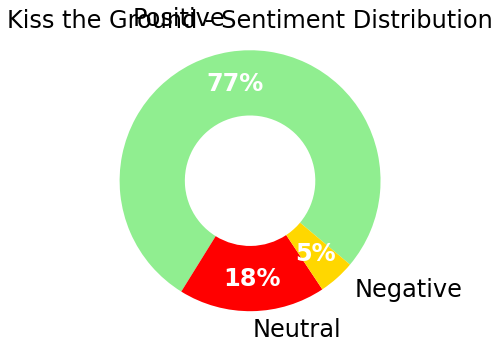

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets20KTG.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'red', 'gold','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Kiss the Ground - Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## A Life on our Planet - Sentiment Analysis

In [ ]:
tweets20ALP = tweets20.loc[(tweets20.ALifeOnOurPlanet == 1)]

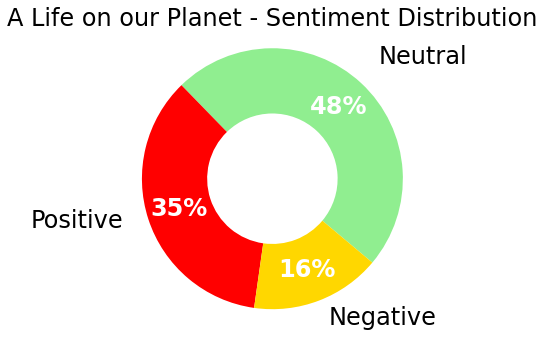

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets20ALP.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'red', 'gold','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("A Life on our Planet - Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## Down to Earth - Sentiment Analysis

In [ ]:
tweets20DTE = tweets20.loc[(tweets20.DownToEarth == 1)]

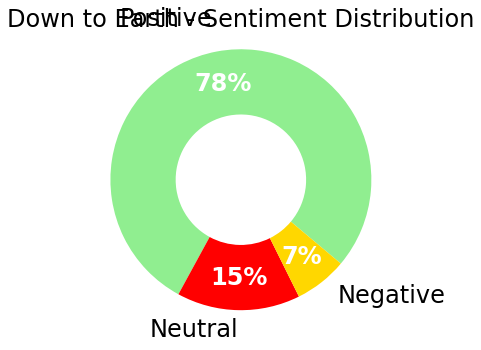

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets20DTE.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'red', 'gold','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Down to Earth - Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## Netflix 2021 Tweets

---



## Preprocess Tweets

In [ ]:
pd.set_option('max_colwidth', 20)
tweets21 = pd.read_json('netflixUSA2021.json', lines=True)

# Set-up patterns to be removed fro the tweets
pat1 = r"http\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
pat7 = r"\n"
pat8 = '\r\n'
pat9 = r'|'.join((r'&amp;',r'&copy;',r'&reg;',r'&quot;',r'&gt;',r'&lt;',r'&nbsp;',r'&apos;',r'&cent;',r'&euro;',r'&pound;'))
# Combine all patterns
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7, pat8, pat9))

# replace the patterns with an empty string
tweets21['stripped'] =  [re.sub(combined_pat, '', w) for w in tweets21.content]

# might have double spaces now (because of empty string replacements above) - remove double empty spaces
tweets21['stripped']  = [re.sub(r"  ", ' ', w) for w in tweets21.loc[:,'stripped']]

In [ ]:
# Instantiate the sentiment analyzer
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
tweets21['C_Score'] = np.nan
for index, row in tweets21.iterrows(): 
    tweets21.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']

In [ ]:
# create new column
sentiment21 = []

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in tweets21.iterrows(): 
    if tweets21.loc[index, 'C_Score'] > 0.05 : 
        sentiment21.append("Positive")      
    elif tweets21.loc[index, 'C_Score'] < -0.05 :
        sentiment21.append("Negative")    
    else :
        sentiment21.append("Neutral")    

tweets21['Sentiment'] = sentiment21
tweets21['Sentiment'] = tweets21['Sentiment'].astype("category")

##Sentiment Distribution

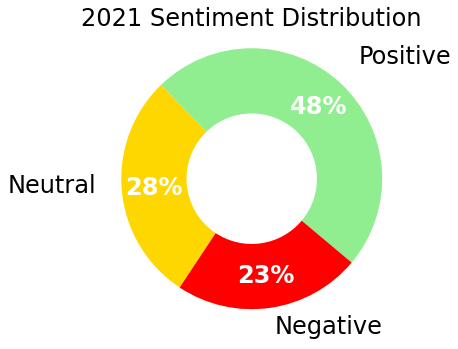

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9,6), subplot_kw=dict(aspect='equal'))

#Get count by sentiment category from tweets21
sentiment_counts21 = tweets21.Sentiment.value_counts()
labels = sentiment_counts21.index

# Define colors
color_palette_list = ['lightgreen', 'gold', 'red', 'orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts21, wedgeprops=dict(width=0.5), startangle=-40,
        colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
  ang = (p.theta2 - p.theta1)/2.+ p.theta1
  y = np.sin(np.deg2rad(ang))
  x = np.cos(np.deg2rad(ang))
  horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
  connectionstyle = "angle,angleA=0,angleB={}".format(ang)
  ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y), 
              horizontalalignment=horizontalalignment)
  
# Set Title
ax.set_title("2021 Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

In [ ]:
import numpy as np
import re

# Let's try to identify tweets that are about the environment
tweets21['environment'] = np.where(tweets21.stripped.str.contains('(?:^|\W)(carbon|emissions|footprint|pollute|pollution|energy|waste|environment)(?:$|\W)',                                                                                                      # beer|booze|brew|bottle|pint|hops|drink|beach
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about carbon emissions
tweets21['carbon'] = np.where(tweets21.stripped.str.contains('(?:^|\W)(carbon emissions|carbon footprint)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about watching netflix for too long
tweets21['watch'] = np.where(tweets21.stripped.str.contains('(?:^|\W)(binge|hours|long|watch|habit)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)

# Let's try to identify tweets that are about cutting back on Netflix
tweets21['habits'] = np.where(tweets21.stripped.str.contains('(?:^|\W)(stop binging|cut back|stop watching|watch less)(?:$|\W)',                                                                                    # (virus|covid-19|SARS-COV-2|vaccine|cough|coronavirus|mask|sick|spread|pandemic|death|covid|hospital|n95|ventilator|respiratory)(?:$|\W)',
    flags = re.IGNORECASE), 1, 0)
 
# How many tweets of each topic?
print(f"Environment {tweets21['environment'].sum()}")
print(f"Carbon Emissions {tweets21['carbon'].sum()}")
print(f"Watch {tweets21['watch'].sum()}")
print(f"Habits {tweets21['habits'].sum()}")

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Environment 323
Carbon Emissions 4
Watch 14424
Habits 144


###Sentiment Distribution over Tweets about Environment

In [ ]:
tweets21enviro = tweets21.loc[(tweets21.environment == 1)]

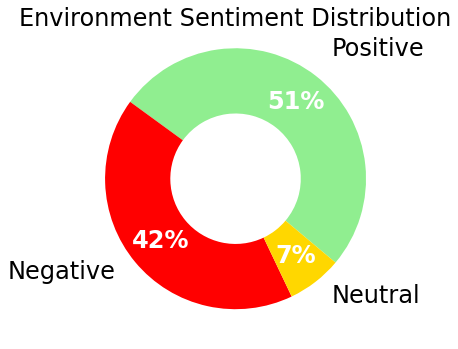

In [ ]:
# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets21enviro.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'red', 'gold','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Environment Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

### Sentiment Distribution over Tweets about Watching Habits

In [ ]:
tweets21watch = tweets21.loc[(tweets21.watch == 1)]

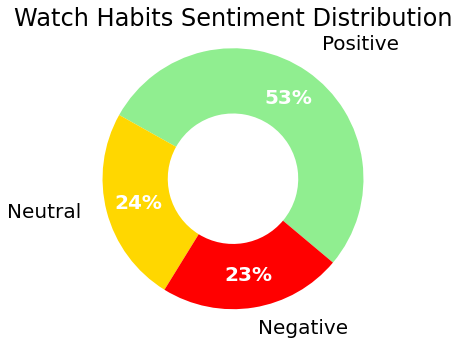

In [ ]:
# Set font size
plt.rcParams['font.size']=20

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets21watch.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'gold', 'red','orange']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Watch Habits Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

## Negative Word Clouds

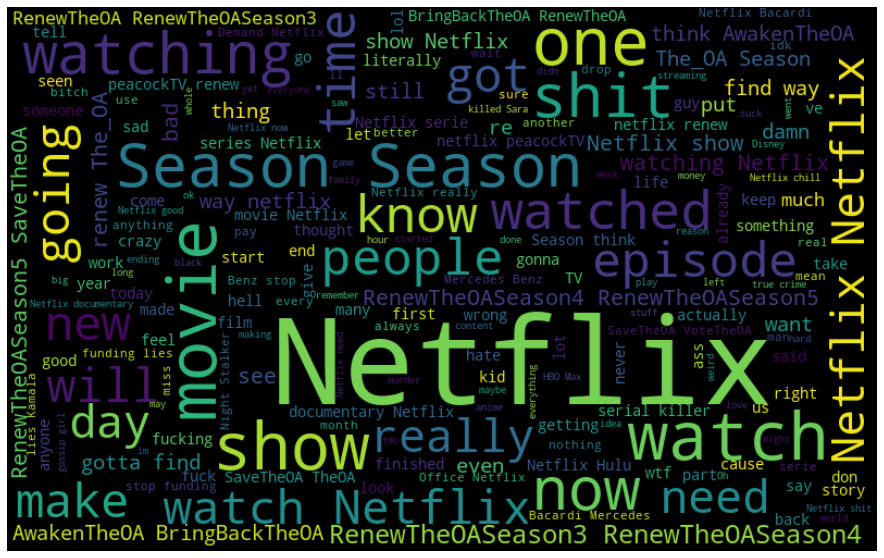

In [ ]:
# 1. Import module 
from wordcloud import WordCloud

# 2. Create bag of words for tweets of Negative sentiment
all_neg_words = ' '.join([text for text in tweets21[tweets21['Sentiment'] == 'Negative']['stripped']])

# 3. Generate Word Cloud
wordcloud = WordCloud(collocations=True, width=800, height=500, random_state=5, max_font_size=110).generate(all_neg_words)

# 4. Visulaize Cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Negative Word Cloud for Tweets About the Environment

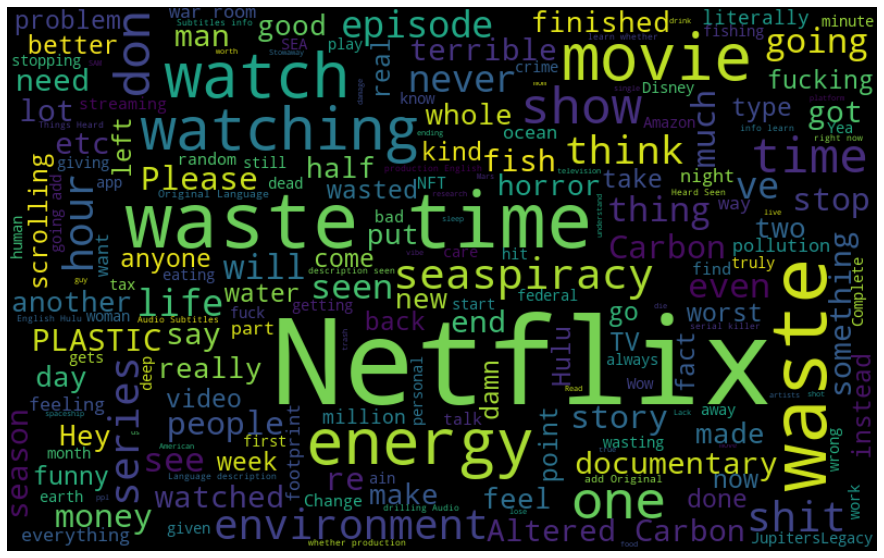

In [ ]:
# 1. Create bag of words for tweets of Negative sentiment
all_neg_words = ' '.join([text for text in tweets21enviro[tweets21enviro['Sentiment'] == 'Negative']['stripped']])

# 2. Generate Word Cloud
wordcloud = WordCloud(collocations=True, width=800, height=500, random_state=5, max_font_size=110).generate(all_neg_words)

# 3. Visulaize Cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()